In [2]:
'''
reader() processes the desired info ['all'] or a list of heuristic names for the num_best agents
of batches described by the step number
'''
def weights_reader(step, info, num_best):
    import re
    
    log_path = "milestone_exp2.log"
    
    read = False
    batch_num = step
    temp_result = ""
    batch_result = []
    result = []
    agent_num = 0
    
    with open(log_path, "r") as log:
        for line in log:
            if read:
                temp_result += line
            
                if "}," in line:
                    read = False
                    
                    float_regex = re.compile(r'\d+\.\d+')
                    if info == ['all']:
                        lst = [float(match.group()) for match in re.finditer(float_regex, temp_result)]
                    else:
                        pattern = ""
                        for i in info:
                            if pattern != "":
                                pattern += "|"
                            pattern += re.escape(str(i)+": ") + '\"\d+\.\d+\"'
                        temp_str = ""
                        for match in re.finditer(pattern, temp_result):
                            temp_str += match.group()
                        lst = [match.group() for match in re.finditer(float_regex, temp_str)]
                    
                    fmt_str = "".join((str(x) + " ") for x in lst)
                    batch_result.append(fmt_str.strip())
                    
                    agent_num += 1
                    temp_result = ""
                    
                    if agent_num == num_best:
                        result.append((batch_num, batch_result))
                        batch_num += step
                        batch_result = []
                        agent_num = 0
                    else:
                        read = True
                    
                
            if "Batch #" + str(batch_num) in line:
                read = True
                
    return result

In [3]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#6790df', '#495999', '#5c9b8b', '#4b6e44', '#7ace63', '#cb67d8']

def elo_reader(step, path):
    import re
    
    batch_num = step
    temp_result = ""
    result = []
    
    with open(path, "r") as log:
        for line in log:
            if "Elos of batch " + str(batch_num) in line:
                temp_result = line.split(": ")[1]
                int_regex = re.compile(r'\d+')
                lst = [int(match.group()) for match in re.finditer(int_regex, temp_result)]

                result.append((batch_num, lst))
                batch_num += step
                temp_result = ""
                
    return result

def heuristic_reader(heuristic, step, path):
    import re
    
    batch_num = step
    temp_result = ""
    result = []
    read = False
    
    with open(path, "r") as log:
        for line in log:
            if read:
                temp_result += line
                
                if "]" in line:
                    read = False
                    float_regex = re.compile(r'\d+\.\d+')
                    heuristic_regex = re.escape(heuristic+": ") + '\"\d+\.\d+\"'
                    temp_str = ""
                    for match in re.finditer(heuristic_regex, temp_result):
                        temp_str += match.group()
                    lst = [float(match.group()) for match in re.finditer(float_regex, temp_str)]
                    
                    result.append((batch_num, lst))
                    temp_result = ""
                    batch_num += step
            
            if "Running batch #" + str(batch_num) in line:
                read = True
                
    return result

def helper(counter, num_children):
    if counter > 5*num_children:
        return 5
    else:
        return counter // num_children

def elo_distplotter(lst, num_children):
    batch_num = [[], [], [], [], [], []]
    elos = [[], [], [], [], [], []]
    
    for i in lst:
        counter = 0
        for j in i[1]:
            batch_num[helper(counter, num_children)].append(i[0])
            elos[helper(counter, num_children)].append(j)
            counter += 1

    ax = plt.figure(figsize=(10,10))
    for i in range(5):
        plt.scatter(batch_num[i], elos[i], alpha=0.5, color=colors[i], label="Parent "+str(i+1))
    plt.scatter(batch_num[5], elos[5], alpha=0.7, color=colors[5], label='Random')
    plt.xlabel("Generation")
    plt.ylabel("Elo")

    legend = plt.legend(bbox_to_anchor=(0, 1, 1, 0.03), facecolor='white', markerscale=1.5, frameon=False, mode="expand", ncols = 6, fontsize=12, handletextpad=0.1)
    
def heuristic_distplotter(lst, heuristic, num_children):
    batch_num = [[], [], [], [], [], []]
    elos = [[], [], [], [], [], []]
    
    for i in lst:
        counter = 0
        for j in i[1]:
            batch_num[helper(counter, num_children)].append(i[0])
            elos[helper(counter, num_children)].append(j)
            counter += 1

    plt.figure(figsize=(10,10))
    for i in range(5):
        plt.scatter(batch_num[i], elos[i], alpha=0.5, color=colors[i], label="Parent "+str(i+1))
    plt.scatter(batch_num[5], elos[5], alpha=0.7, color=colors[5], label='Random')
    plt.xlabel(heuristic)
    plt.ylabel("Weight")

    legend = plt.legend(bbox_to_anchor=(0, 1, 1, 0.03), facecolor='white', markerscale=1.5, frameon=False, mode="expand", ncols = 6, fontsize=12, handletextpad=0.1)
    
def corr(lst1, lst2):
    eloheuristic_corr = []
    for i in range(len(lst1)):
        eloheuristic_corr.append((lst1[i][0], np.corrcoef(lst1[i][1], lst2[i][1])[0,1]))
        
    return eloheuristic_corr

def eloheuristic_corrplotter(lst, title):
    batch_num = []
    corrs = []
    
    for i in lst:
        batch_num.append(i[0])
        corrs.append(i[1])
        
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.plot(batch_num, corrs)
    plt.xlabel("Generation")
    plt.ylabel("Correlation")

In [4]:
elo_dist2 = elo_reader(4, "milestone_exp2.log")
elo_dist3 = elo_reader(4, "milestone_exp3.log")

In [5]:
import requests
from tempfile import NamedTemporaryFile
import matplotlib.font_manager as fm
import seaborn as sns

pt_serif = 'https://github.com/google/fonts/raw/a4f3deeca2d7547351ff746f7bf3b51f5528dbcf/ofl/ptserif/PT_Serif-Web-Regular.ttf'
google_font_response = requests.get(pt_serif)

font_name = None
font_prop = None
with NamedTemporaryFile(delete=False, suffix='.ttf') as f:
  font_name = f.name
  f.write(google_font_response.content)

  fm.fontManager.addfont(font_name)
  font_prop = fm.FontProperties(fname=font_name)
  # sns.set(font=font_prop.get_name())

In [6]:
from matplotlib import rcParams

sns.set_style(rc={"font.sans-serif":font_prop.get_name()})
sns.set_context(rc={"axes.labelsize": 18})
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

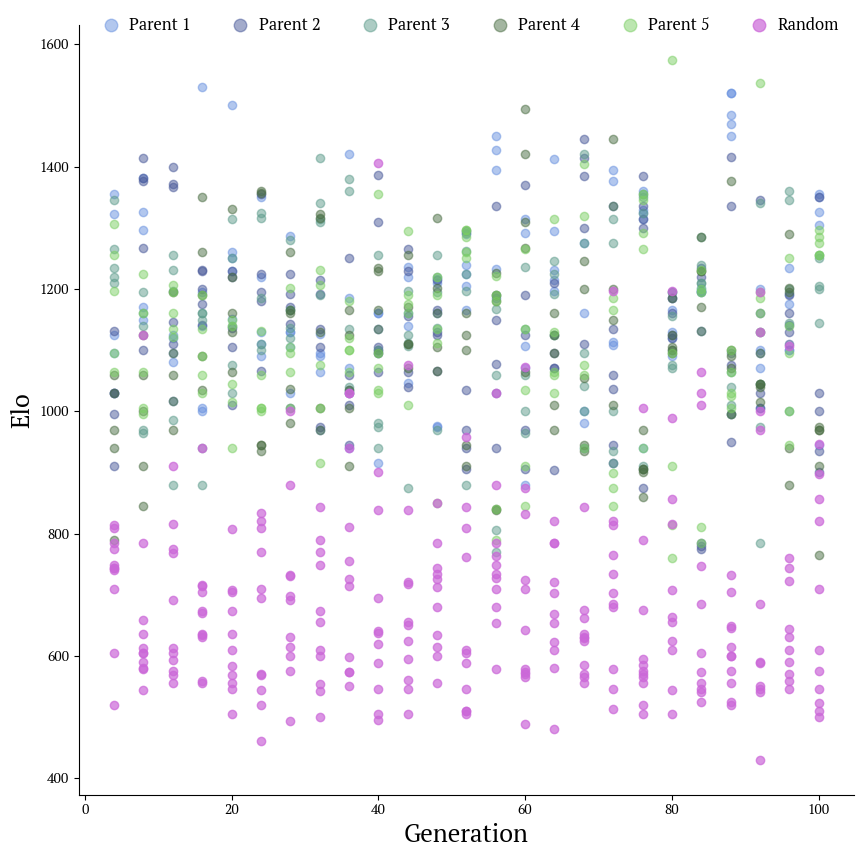

In [7]:
elo_distplotter(elo_dist2, 5)

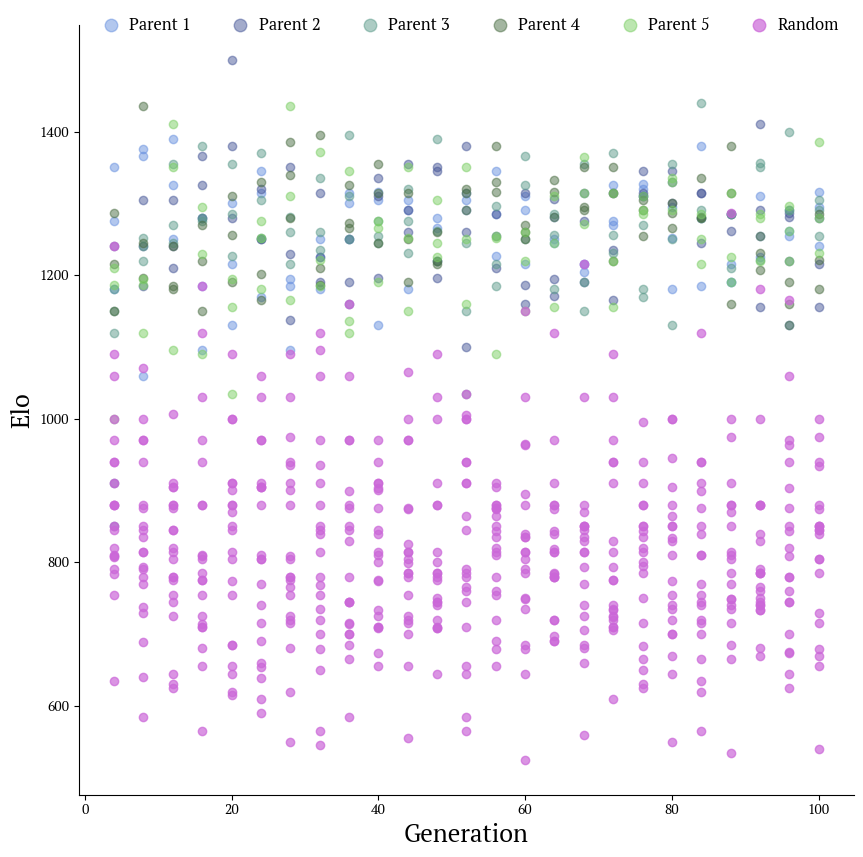

In [8]:
elo_distplotter(elo_dist3, 3)

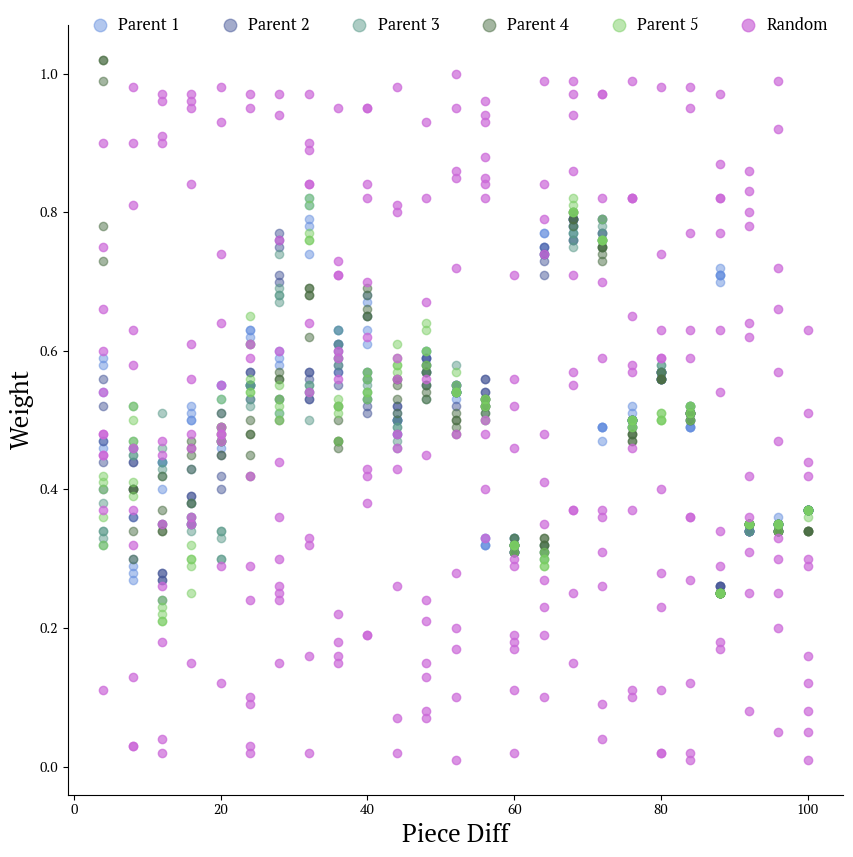

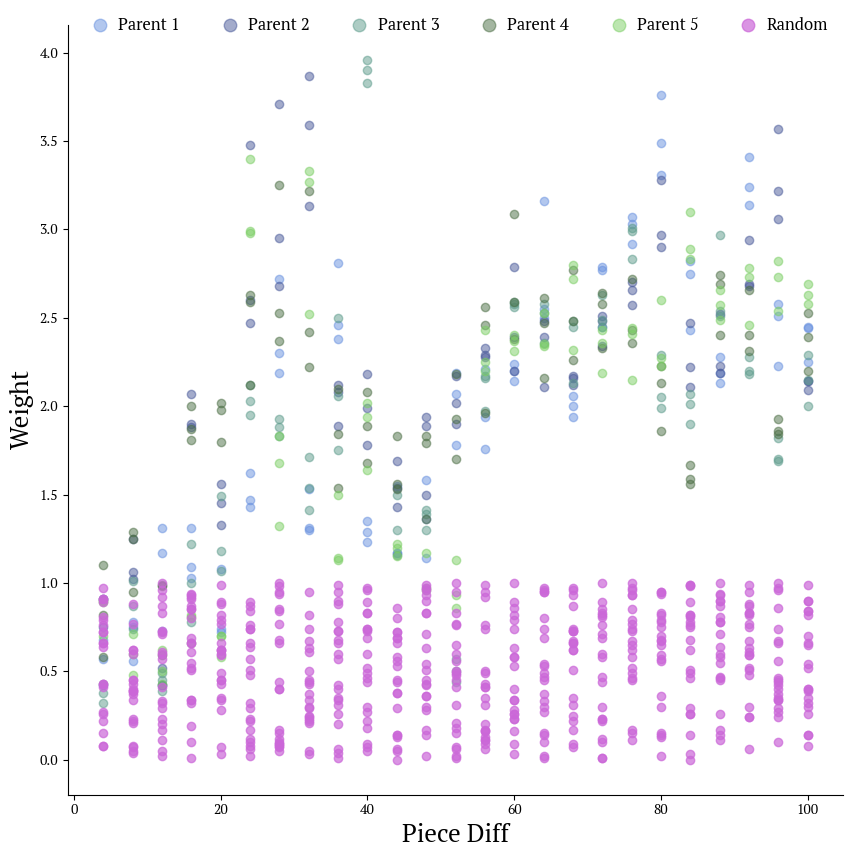

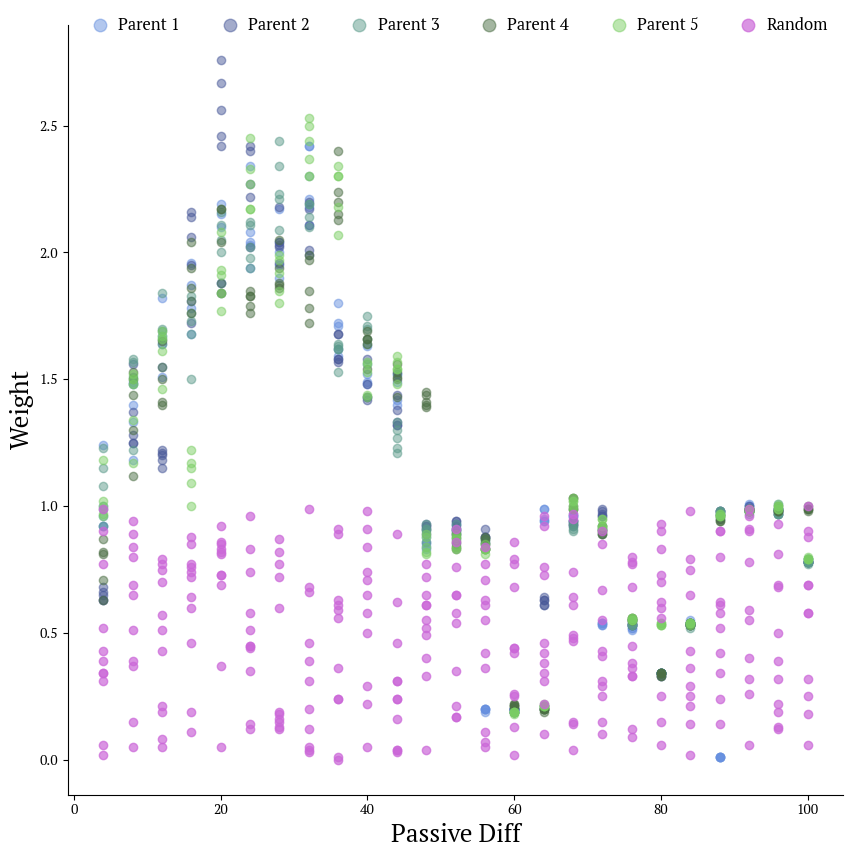

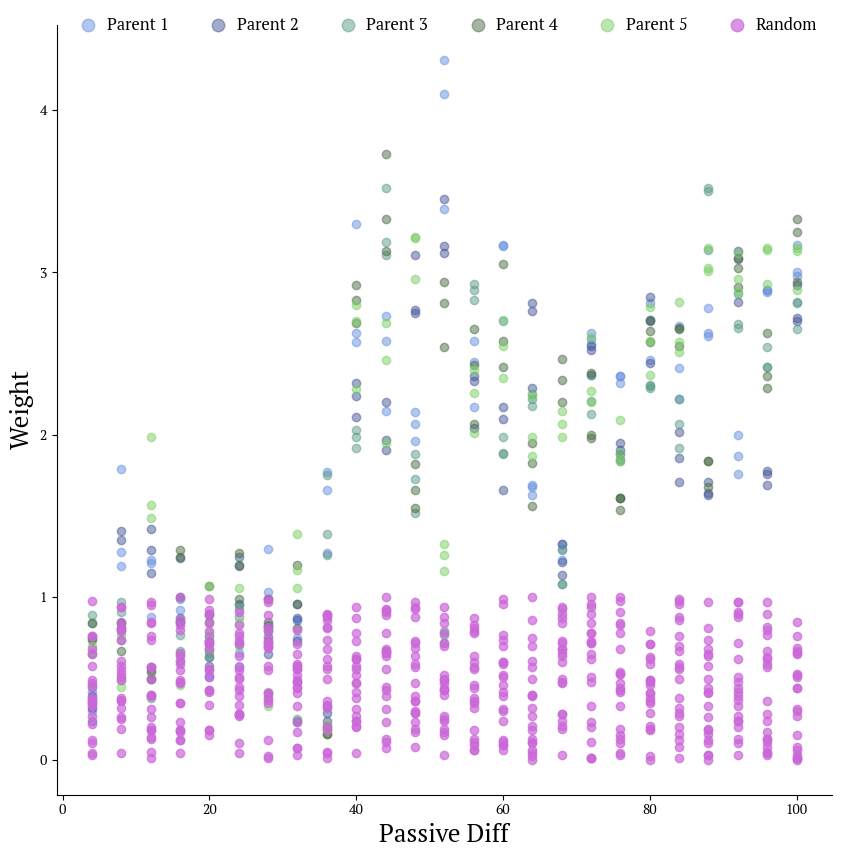

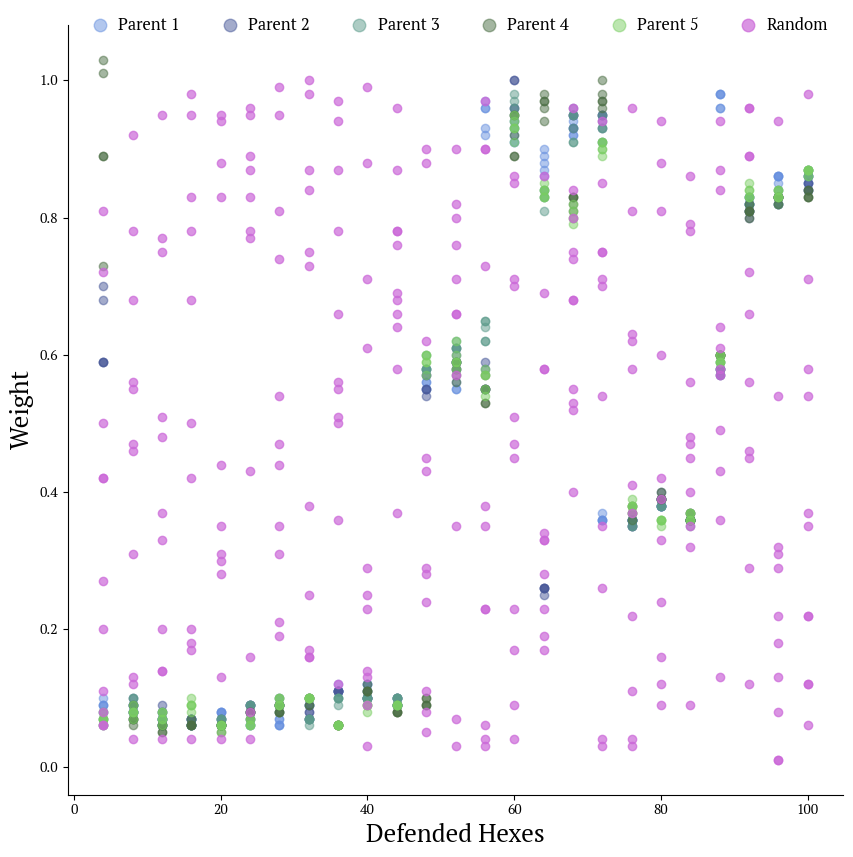

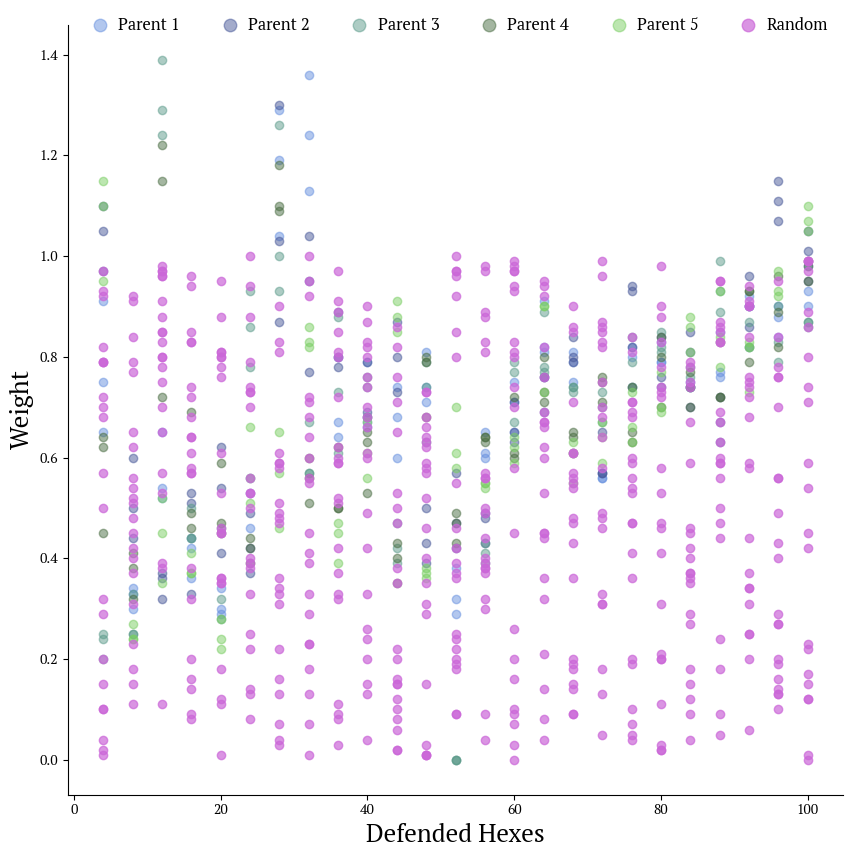

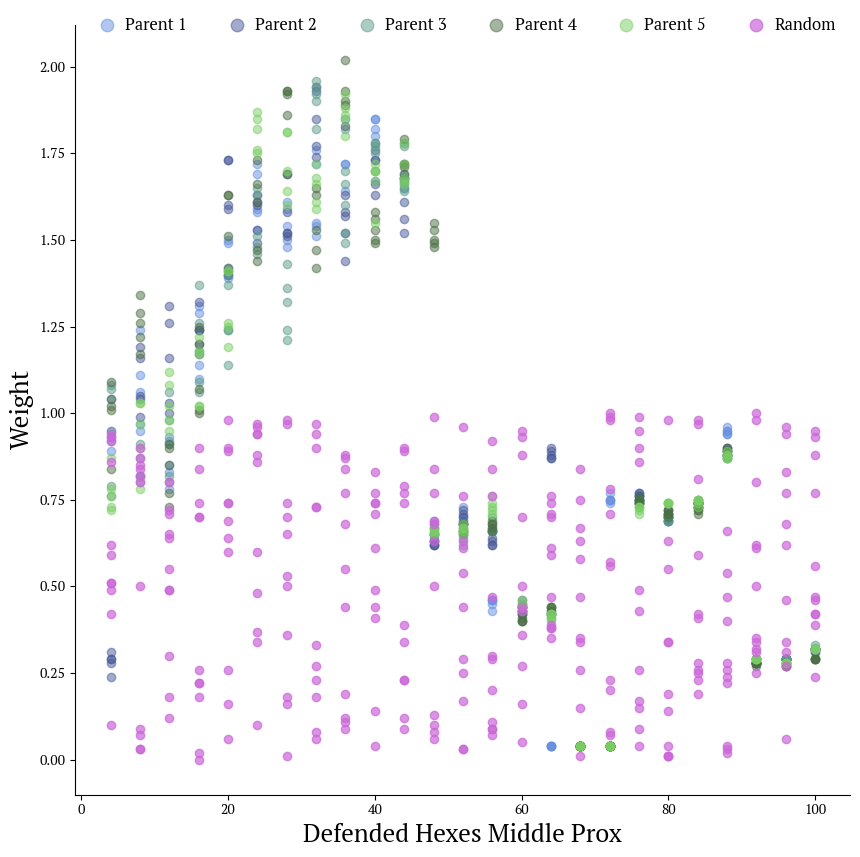

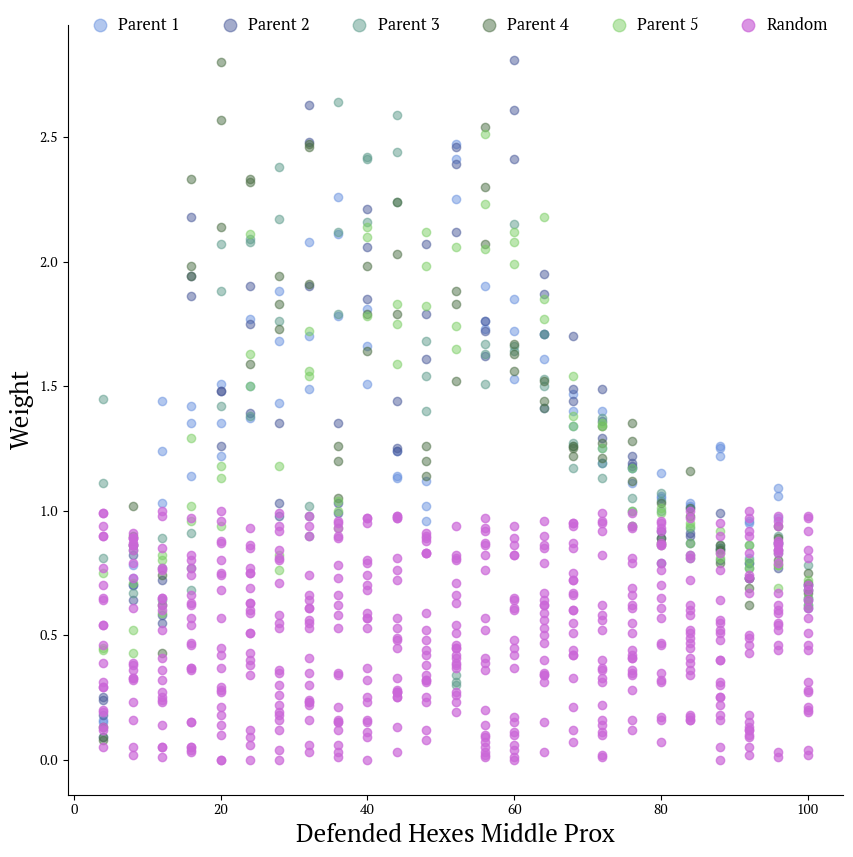

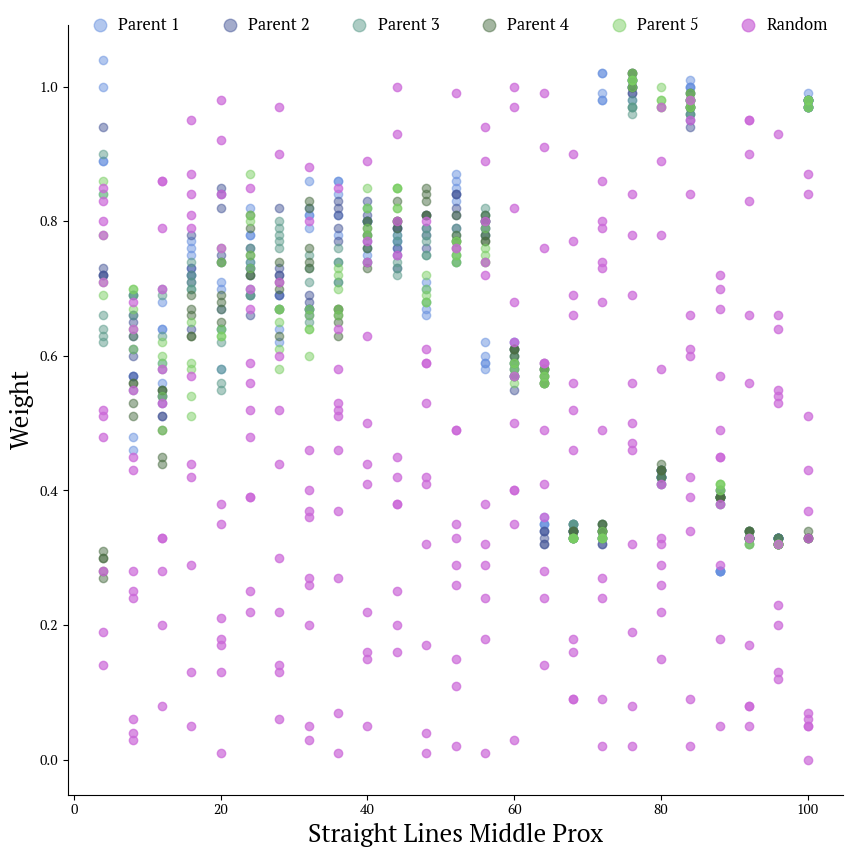

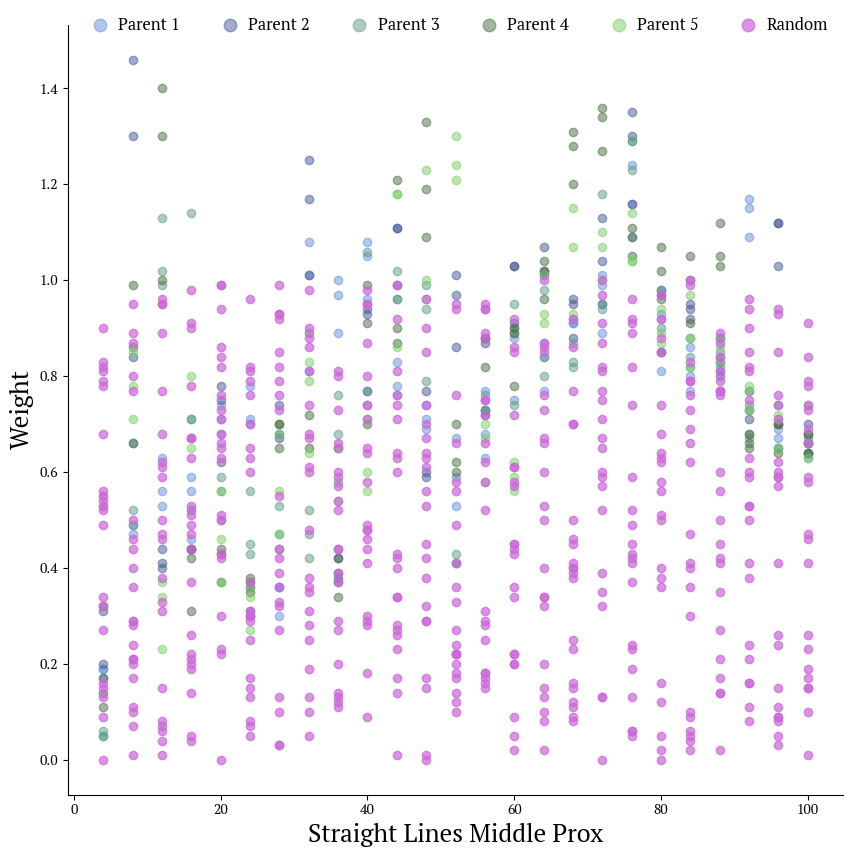

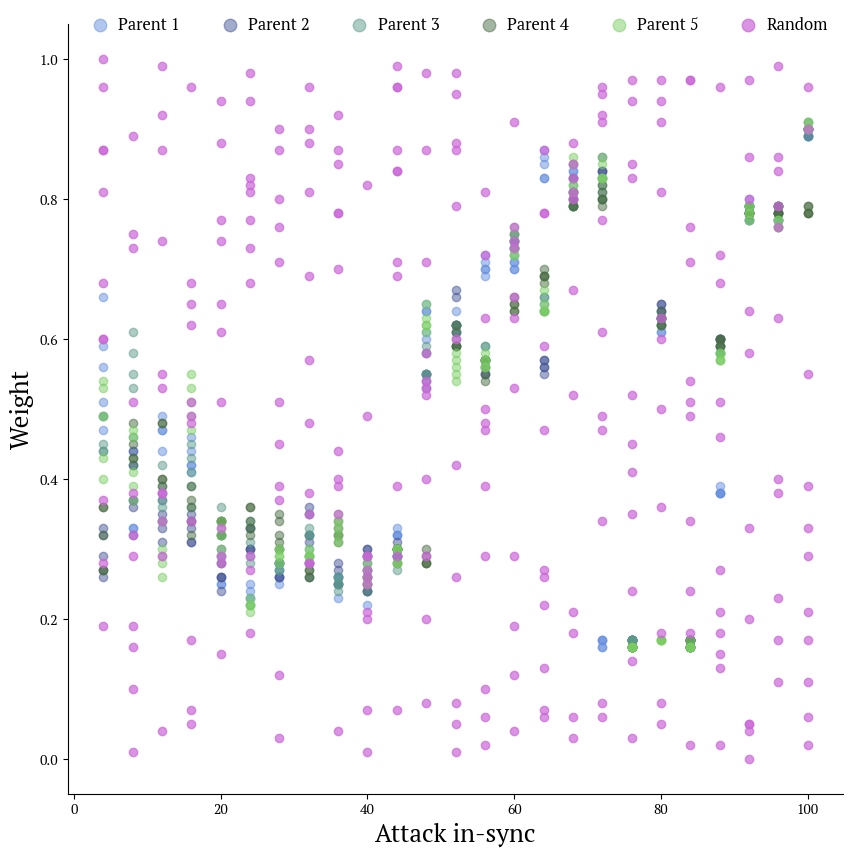

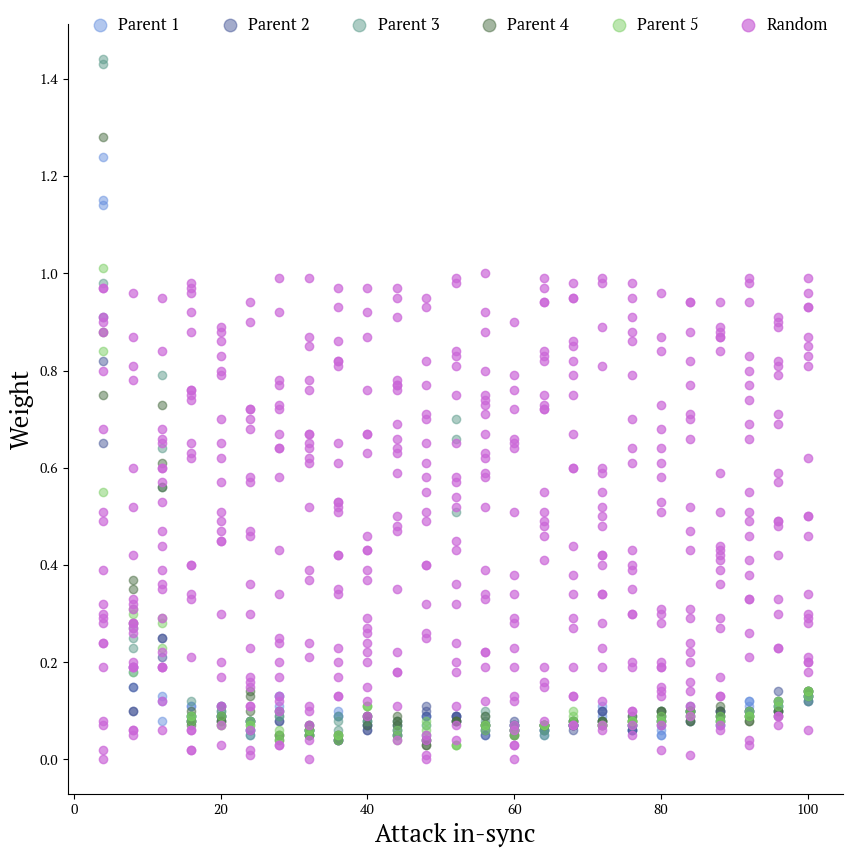

In [9]:
for i in ['Piece Diff', 'Passive Diff', 'Defended Hexes', 'Defended Hexes Middle Prox', 'Straight Lines Middle Prox', 'Attack in-sync']:
    heuristic_distplotter(heuristic_reader(i, 4, "milestone_exp2.log"), i, 5)
    heuristic_distplotter(heuristic_reader(i, 4, "milestone_exp3.log"), i, 3)